In [1]:
import pickle
import numpy as np
import os
import gzip
import matplotlib.pyplot as plt

from model import Model
from utils import *
# from tensorboard_evaluation import Evaluation

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
def read_data(datasets_dir="./data", frac = 0.1):
    """
    This method reads the states and actions recorded in drive_manually.py 
    and splits it into training/ validation set.
    """
    
    print("... read data")
    data_file = os.path.join(datasets_dir, 'data.pkl.gzip')
    
    f = gzip.open(data_file,'rb')
    data = pickle.load(f)
    
    # get images as features and actions as targets
    X = np.array(data["state"]).astype('float32')
    y = np.array(data["action"]).astype('float32')
    
    n_samples = len(data["state"])
    X_train, y_train = X[:int((1-frac) * n_samples)], y[:int((1-frac) * n_samples)]
    X_valid, y_valid = X[int((1-frac) * n_samples):], y[int((1-frac) * n_samples):]
    
    return X_train, y_train, X_valid, y_valid


def preprocessing(X_train, y_train, X_valid, y_valid, history_length=1):
    # TODO: preprocess your data here.
    # 1. convert the images in X_train/X_valid to gray scale. If you use rgb2gray() from utils.py, the output shape (96, 96, 1)
    # 2. you can either train your model with continous actions (as you get them from read_data) using regression
    #    or you discretize the action space using action_to_id() from utils.py. If you discretize them, you'll maybe find one_hot() 
    #    useful and you may want to return X_train_unhot ... as well.
    # 
    # # History:
    # At first you should only use the current image as input to your network to learn the next action. Then the input states
    # have shape (96, 96,1). Later, add a history of the last N images to your state so that a state has shape (96, 96, N).
    X_train = rgb2gray(X_train)
    X_valid = rgb2gray(X_valid)
    
    for batch_id in X_train.shape[0] / history_length:
        
    
    return X_train, y_train, X_valid, y_valid



In [15]:

def train_model(X_train, y_train, X_valid, y_valid, n_minibatches, batch_size, lr, model_dir="./models", tensorboard_dir="./tensorboard"):
    
    # create result and model folders
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    if not os.path.exists(tensorboard_dir):
        os.mkdir(tensorboard_dir)
 
    print("... train model")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    train_dataset = TensorDataset(torch.Tensor(X_train).float(), torch.Tensor(y_train).float())
    val_dataset = TensorDataset(torch.Tensor(X_valid).float(), torch.Tensor(y_valid).float())
    train_loader = DataLoader(
        train_dataset,
        batch_size = batch_size
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size = batch_size
    )

    agent = Model()
    agent.model = agent.model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(agent.model.parameters(), lr = lr)

    train_losses = []
    val_losses = []
    for epoch in range(n_minibatches):
        # print(f'-- running epoch {epoch + 1} --')
        
        total_train_loss = 0
        count = 0
        for X, y in train_loader:
            X = X.unsqueeze(1)
            X = X.to(device)
            y = y.to(device)
            out = agent.model(X)
            loss = criterion(out, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += float(loss) * X.shape[0]
            count += X.shape[0]
        
        avg_train_loss = total_train_loss / count


        with torch.no_grad():
            total_val_loss = 0
            count = 0
            for X, y in val_loader:
                X = X.unsqueeze(1)
                X = X.to(device)
                y = y.to(device)
                out = agent.model(X)
                loss = criterion(out, y)

                total_val_loss += float(loss) * X.shape[0]
                count += X.shape[0]
            
            avg_val_loss = total_val_loss / count


        print(f'epoch = {epoch}, train_loss = {avg_train_loss}, val_loss = {avg_val_loss}')
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
    # TODO: save your agent
    model_dir = agent.save(os.path.join(model_dir, "agent.ckpt"))
    print("Model saved in file: %s" % model_dir)


In [18]:
X_train, y_train, X_valid, y_valid = read_data("/scratch/prs392/data")
X_train, y_train, X_valid, y_valid = preprocessing(X_train, y_train, X_valid, y_valid, history_length=1)

# train model (you can change the parameters!)
train_model(X_train, y_train, X_valid, y_valid, n_minibatches=100, batch_size=64, lr=0.0001)
 


... read data
... train model
epoch = 0, train_loss = 0.10458575809995334, val_loss = 0.13895061612129211
epoch = 1, train_loss = 0.07675800413051818, val_loss = 0.13406339287757874
epoch = 2, train_loss = 0.06390827323528046, val_loss = 0.1308826059103012
epoch = 3, train_loss = 0.05217853227154689, val_loss = 0.13159938156604767
epoch = 4, train_loss = 0.04912314527000941, val_loss = 0.13718262314796448
epoch = 5, train_loss = 0.043961982619255144, val_loss = 0.14098286628723145
epoch = 6, train_loss = 0.04268992981206335, val_loss = 0.13418854773044586
epoch = 7, train_loss = 0.042391271868733864, val_loss = 0.13703402876853943
epoch = 8, train_loss = 0.042215107926927134, val_loss = 0.15813256800174713
epoch = 9, train_loss = 0.036886760707389804, val_loss = 0.1607581228017807
epoch = 10, train_loss = 0.03506738842788634, val_loss = 0.15335895121097565
epoch = 11, train_loss = 0.03150863578569488, val_loss = 0.15174199640750885
epoch = 12, train_loss = 0.029719426967071513, val_los

In [20]:
import seaborn as sns

sns.set_style('darkgrid')
epoch_df = pd.DataFrame(
    data = zip(list(
        range(1, 101), 
        train_losses,
        val_losses
    )),
    columns = ['epoch', 'train_loss', 'val_loss']
)
sns.lineplot(data=epoch_df, x="epoch", y="train_loss")
sns.lineplot(data=epoch_df, x="epoch", y="val_loss")

ModuleNotFoundError: No module named 'seaborn'

In [23]:
train_losses = [
0.10458575809995334,
0.07675800413051818,
0.06390827323528046,
0.05217853227154689,
0.04912314527000941,
0.043961982619255144,
0.04268992981206335,
0.042391271868733864,
0.042215107926927134,
0.036886760707389804,
0.03506738842788634,
0.03150863578569488,
0.029719426967071513,
0.028312697950486385,
0.025288637180924944,
0.025173691202100393,
0.02392322424442527,
0.02069882390498851,
0.01937163977863941,
0.018896038966015615,
0.017086832490188223,
0.017133544841517055,
0.016237397811950206,
0.015015343291658564,
0.015110681493971365,
0.014846099955062812,
0.014309038475803133,
0.01421352098068447,
0.014067882636449702,
0.012936937250362062,
0.011940496096863075,
0.012455076005653286,
0.013715483832787326,
0.01499689434298334,
0.013166324225591218,
0.011390532346290424,
0.010477368736388624,
0.009798357080740868,
0.010022302312571688,
0.010499074192327968,
0.009886522583353022,
0.00914058077078088,
0.00851024155742786,
0.007306958488452889,
0.005830565421653793,
0.006079389858604508,
0.005550701371171174,
0.005535321343188167,
0.006614948411931198,
0.008085871285821661,
0.009556850262815199,
0.010148842714178699,
0.009802216596666935,
0.007931119245510047,
0.007594914677559484,
0.007496736459277161,
0.006878525931024858,
0.005785283628035443,
0.005589861003764581,
0.004863608877442064,
0.004588983557104457,
0.0045277604346942975,
0.004845810524874915,
0.005319181844552464,
0.0054001129776856975,
0.0063347220348593854,
0.0060133858933113515,
0.005922683485963626,
0.006732866638843696,
0.006153593169267666,
0.005252242387818991,
0.0042449398416652614,
0.003936787117528564,
0.0032430047081397012,
0.00323705986168579,
0.003454871319650494,
0.0032894765722469577,
0.003937988296392248,
0.005659483445202272,
0.006177096367163042,
0.006226603621872908,
0.005493532344434701,
0.00555703931645794,
0.005493905312292516,
0.006712349869619646,
0.004959073399873913,
0.00335112679378189,
0.003228827969976932,
0.0026391511213311805,
0.0027754941080236173,
0.0030888764174070524,
0.0037892930263716145,
0.0041386929597847615,
0.004150578807374786,
0.004636054386298919,
0.004645925082087992,
0.005035767252251492,
0.006028506464464425,
0.006883235709578234,
0.005698328363834649,
]

In [25]:
val_losses = [
0.13895061612129211,
0.13406339287757874,
0.1308826059103012,
0.13159938156604767,
0.13718262314796448,
0.14098286628723145,
0.13418854773044586,
0.13703402876853943,
0.15813256800174713,
0.1607581228017807,
0.15335895121097565,
0.15174199640750885,
0.14669139683246613,
0.14211614429950714,
0.15309587121009827,
0.13951162993907928,
0.1364162266254425,
0.1350998729467392,
0.13555385172367096,
0.13488425314426422,
0.1370445191860199,
0.14433084428310394,
0.1522972285747528,
0.15187492966651917,
0.1380975842475891,
0.13573411107063293,
0.1327713429927826,
0.13113240897655487,
0.13011421263217926,
0.13066574931144714,
0.1327769160270691,
0.13422349095344543,
0.13448908925056458,
0.14150911569595337,
0.14274261891841888,
0.15255893766880035,
0.15348252654075623,
0.1468554586172104,
0.1424105167388916,
0.14820683002471924,
0.14424073696136475,
0.14725954830646515,
0.1439262181520462,
0.1365053653717041,
0.132141575217247,
0.13200685381889343,
0.13677461445331573,
0.14327651262283325,
0.1445010006427765,
0.13892844319343567,
0.13439035415649414,
0.14031808078289032,
0.14774742722511292,
0.150085911154747,
0.15186165273189545,
0.1467374861240387,
0.13716742396354675,
0.13761666417121887,
0.14389149844646454,
0.14626549184322357,
0.14584530889987946,
0.1487179696559906,
0.13924653828144073,
0.13969027996063232,
0.15415136516094208,
0.16458818316459656,
0.16378919780254364,
0.14706005156040192,
0.14126981794834137,
0.14932498335838318,
0.1497209668159485,
0.15018682181835175,
0.15035171806812286,
0.14849171042442322,
0.1429765671491623,
0.1495499163866043,
0.14699484407901764,
0.15058110654354095,
0.15195438265800476,
0.1471908688545227,
0.1436638981103897,
0.15865670144557953,
0.16780155897140503,
0.1635851114988327,
0.14557065069675446,
0.14576594531536102,
0.1512986272573471,
0.15284132957458496,
0.15333980321884155,
0.15205587446689606,
0.15275685489177704,
0.1487305760383606,
0.1442456841468811,
0.14309906959533691,
0.14379331469535828,
0.1475100815296173,
0.15841181576251984,
0.1564527451992035,
0.156615749001503,
0.15484941005706787,
]

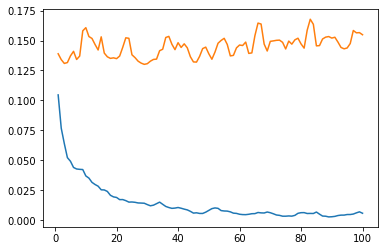

In [26]:
plt.plot(list(range(1, 101)), train_losses)
plt.plot(list(range(1, 101)), val_losses)`

In [19]:
!pwd

/home/ns4486/repos/deep-rl/hw/hw1


In [27]:
X_train.shape

(18000, 96, 96)